# 2016C 50193
使用了K均值、PCA和AHP、灰色GM(1,1)、时间序列、MILP
## 大致流程
### 1.数据处理
首先利用UNITID连接两个表

然后删去缺失数据过多的行

参数合并：线性拟合＋PCA

填补缺失值：K均值聚类，缺失值用同一类的均值填补

数据归一化

### 2.构建ROI模型

利润/投入 X系数（紧急程度）

AHP层次分析法：衡量权重

灰色理论，利用过去五年数据（已缺失）预测未来五年数据

### 3.建立一年的基础模型

构建ROI和风险值指标

使用MILP(mixed integer linear programming)求解

### 4.时间序列预测

加入时间因子，改进为时间序列模型

### 5.灵敏度分析

分别改变学校数量、最大可接受风险、金钱分配的时间安排、观察最大收益的变化幅度，以验证4中策略的可行性和算法的鲁棒性。

# 导包

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from numpy import unique
from numpy import where
from sklearn.cluster import KMeans
from matplotlib import pyplot
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import warnings
import os
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)
#print(os.listdir("../input"))

# 数据处理
读取候选学校名单和学校的参数列表

In [2]:
data1 = pd.read_excel('Problem C - IPEDS UID for Potential Candidate Schools.xlsx')
data2 = pd.read_excel('Problem C - Most Recent Cohorts Data (Scorecard Elements).xlsx')
data1.info()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UNITID  2977 non-null   int64 
 1   INSTNM  2977 non-null   object
 2   CITY    2977 non-null   object
 3   STABBR  2977 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Columns: 122 entries, UNITID to gt_25k_p6
dtypes: float64(103), int64(7), object(12)
memory usage: 7.3+ MB


将data1和data2合并，只保留candidates里的学校

结果还剩2936个候选学校

再删除不在运行的学校和遭受经济危机的学校，还剩2911个学校

再删除缺失值过半的学校

In [3]:
data1.drop(columns=['INSTNM','CITY','STABBR'],inplace=True)         #提前删掉两个文档这两列，对后续数据处理没啥用
data2.drop(columns=['INSTNM','CITY','STABBR'],inplace=True)
data3 = pd.merge(data1,data2,on=['UNITID'],how='inner')             #合并，保留UNITID相同的学校作为候选学校
data3 = data3[data3['HCM2']==0]
data3 = data3[data3['CURROPER']==1]                                 #分别除去两类学校
data3.drop(['HCM2','CURROPER'],inplace=True,axis=1)
data3.dropna(thresh=len(data3.columns)*0.5,inplace=True,axis=0) #使剩下的学校缺失值不超过50%,thresh允许的最小有效值数量
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908 entries, 0 to 2935
Columns: 117 entries, UNITID to gt_25k_p6
dtypes: float64(103), int64(5), object(9)
memory usage: 2.6+ MB


## 合并一些指标
根据NPT4_PUB和NPT4_PRIV构造新特征Net Price，删除原来两个特征，我使用的方法是用求和的方法

原论文没说具体是怎么处理的，这里借用了CSDN某用户的处理思路

根据RET_FT4、RET_FTL4、RET_PT4、RET_PTL4构造新的特征RetentionRate，原文说求和这里就求和了

保留ACT和SAT分数的中点値，其他值均删除

In [4]:
data3['Net Price']=data3[['NPT4_PUB','NPT4_PRIV']].sum(axis=1)
data3.drop(['NPT4_PUB','NPT4_PRIV','NPT41_PUB','NPT42_PUB','NPT43_PUB',
            'NPT44_PUB','NPT45_PUB','NPT41_PRIV','NPT42_PRIV','NPT43_PRIV',
            'NPT44_PRIV','NPT45_PRIV'],inplace=True,axis=1)                                  #构造新特征Net Price，再删掉这些特征
data3['RetentionRate']=data3[['RET_FT4','RET_FTL4','RET_PT4','RET_PTL4']].sum(axis=1)        
data3.drop(['RET_FT4','RET_FTL4','RET_PT4','RET_PTL4'],inplace=True,axis=1)                  #构造新特征RetentionRate，再删掉这些特征
temp_SAT=data3[['SATVR25','SATVR75','SATMT25','SATMT75','SATWR25','SATWR75','SATVRMID','SATMTMID','SATWRMID','SAT_AVG','SAT_AVG_ALL']]
SATmin=temp_SAT.min(axis=1)
SATmax=temp_SAT.max(axis=1)
temp_ACT=data3[['ACTCM25','ACTCM75','ACTEN25','ACTEN75','ACTMT25','ACTMT75','ACTWR25','ACTWR75','ACTCMMID','ACTENMID','ACTMTMID','ACTWRMID']]
ACTmin=temp_ACT.min(axis=1)
ACTmax=temp_ACT.max(axis=1)                                                                   #查找一切和SAT和ACT分数有关的特征，求出他们的中点値

In [5]:
data3['SAT']=(SATmin+SATmax)/2              #分别求SAT和ACT分数中点值
data3['ACT']=(ACTmin+ACTmax)/2
data3.drop(['SATVR25','SATVR75','SATMT25','SATMT75','SATWR25','SATWR75','SATVRMID','SATMTMID','SATWRMID',
            'SAT_AVG','SAT_AVG_ALL','ACTCM25','ACTCM75','ACTEN25','ACTEN75','ACTMT25','ACTMT75','ACTWR25',
            'ACTWR75','ACTCMMID','ACTENMID','ACTMTMID','ACTWRMID',],inplace=True,axis=1)          #剔除相关列，简化数据
data3.drop(['OPEID','opeid6','INSTURL','NPCURL'],inplace=True,axis=1)                             #这里又剔除了几列没用的特征
data3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908 entries, 0 to 2935
Data columns (total 78 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNITID                  2908 non-null   int64  
 1   PREDDEG                 2908 non-null   int64  
 2   CONTROL                 2908 non-null   int64  
 3   LOCALE                  2908 non-null   float64
 4   HBCU                    2908 non-null   float64
 5   PBI                     2908 non-null   float64
 6   ANNHI                   2908 non-null   float64
 7   TRIBAL                  2908 non-null   float64
 8   AANAPII                 2908 non-null   float64
 9   HSI                     2908 non-null   float64
 10  NANTI                   2908 non-null   float64
 11  MENONLY                 2908 non-null   float64
 12  WOMENONLY               2908 non-null   float64
 13  RELAFFIL                745 non-null    float64
 14  PCIP01                  2908 non-null   

# K均值聚类
使用K均值聚类，以Integral data columns（论文中提到的）为数据进行聚类

由图可知，可以选择n_clusters=5作为参数，原文也是这么说的

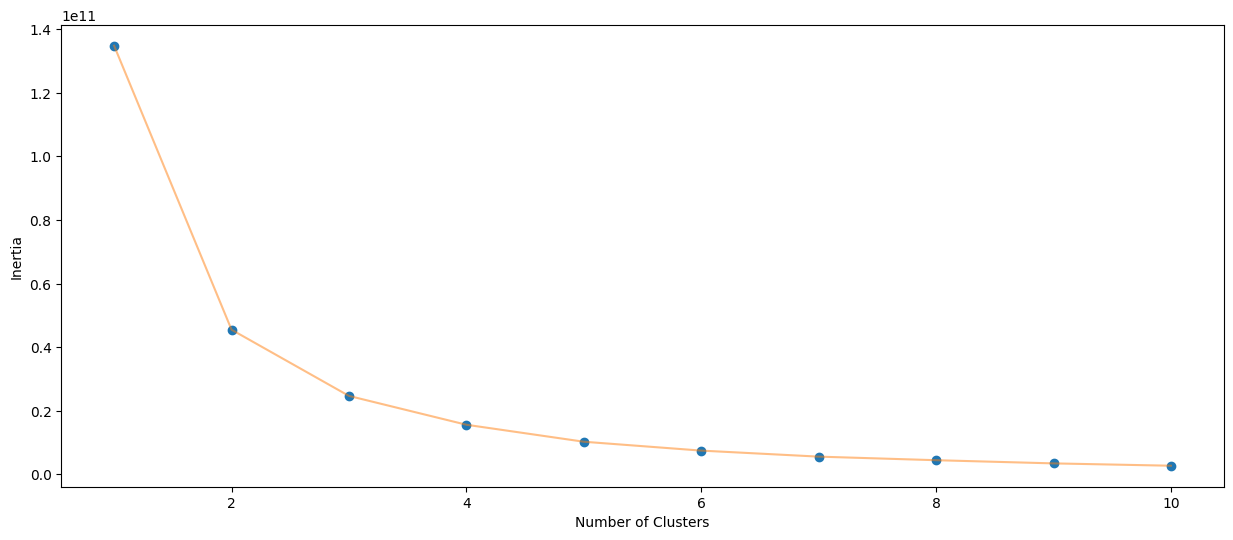

In [6]:
KIndex=np.array(['PREDDEG','CONTROL','HBCU','PBI','ANNHI','TRIBAL','AANAPII',
                'HSI','NANTI','MENONLY','WOMENONLY','DISTANCEONLY',
                'UGDS','PPTUG_EF','PCTFLOAN','PCTPELL'])

KIndex=np.append(KIndex,data3.columns.values[15:52])                                        #KIndex存入了用来聚类的特征索引
KIndex=np.append(KIndex,data3.columns.values[55:64])                                        #完善索引表，用这些数据来进行聚类

Kdata=data3[KIndex]                                                                         #数据集，使用Kdata替代原数据集

X3 = Kdata.fillna(0).iloc[: , :].values                                                     #缺失值用0填充
#这一段开始直接套用即可
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )          
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)                                                      
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()
#这里用来作出图找到最佳类个数

algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_
#K均值聚类过程，其中类别标签保存在参数列表labels3中

## 求出各类别下目标特征值的平均值
'Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP','RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10'

原论文中还有三个指标，但是很奇怪的是没有出现在数据集中，很奇怪

先往下做

In [7]:
data3['label']=labels3
data3.replace('PrivacySuppressed',np.nan,inplace=True)
imputIndex=['Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP',
                    'RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10','PCTPELL','PCTFLOAN','SAT','label','UGDS']         #需要插值的索引
imputAvg=np.zeros(shape=(5,12))                                                                         #用来存放各组特征值的平均值
for i in range(5):                                                                             #实际上只需要对前五个插值
    temp=data3[data3['label']==i]
    for j in range(len(imputIndex)-1):
        AvgOfImput=temp[imputIndex[j]].mean()
        imputAvg[i][j]=AvgOfImput                                                             #保存指标的平均值，有不用的数据，比如label的均值
print(data3)


      UNITID  PREDDEG  CONTROL  LOCALE  HBCU  PBI  ANNHI  TRIBAL  AANAPII  \
0     110486        3        1    11.0   0.0  0.0    0.0     0.0      0.0   
1     110635        3        1    12.0   0.0  0.0    0.0     0.0      0.0   
2     110918        3        2    11.0   0.0  0.0    0.0     0.0      0.0   
3     111188        3        1    12.0   0.0  0.0    0.0     0.0      0.0   
4     111920        2        1    12.0   0.0  0.0    0.0     0.0      0.0   
...      ...      ...      ...     ...   ...  ...    ...     ...      ...   
2931  239460        1        1    13.0   0.0  0.0    0.0     0.0      0.0   
2932  239910        1        1    42.0   0.0  0.0    0.0     0.0      0.0   
2933  433174        2        1    11.0   0.0  0.0    0.0     0.0      0.0   
2934  442523        1        2    41.0   0.0  0.0    1.0     0.0      0.0   
2935  475565        0        1    11.0   0.0  0.0    0.0     0.0      0.0   

      HSI  ...  RPY_3YR_RT_SUPP  C150_4_POOLED_SUPP  C200_L4_POOLED_SUPP  \

## 插值
因为代码功底比较差＋时间不够，这里直接Ctrl+C/V处理代码了

最后得到的数据集都是没有缺失值的(ACT除外，因为根据论文的要求，对ACT的处理要特别一点），数据已经预处理完毕

但是因为原论文中有三个指标，不太清楚是怎么构造出来的，构建模型的话目前就姑且用这些指标了

In [8]:
group_0=data3[data3['label']==0]
group_1=data3[data3['label']==1]
group_2=data3[data3['label']==2]
group_3=data3[data3['label']==3]    
group_4=data3[data3['label']==4]                                            #把各个聚类中的组分开


#这一行这里可以先不管，这是之后求出来的Risk值，因为技术有限就先放在这里求了
Risk=np.zeros(5)
Risk[0]=group_0['md_earn_wne_p10'].std()/group_0['md_earn_wne_p10'].mean()
Risk[1]=group_1['md_earn_wne_p10'].std()/group_1['md_earn_wne_p10'].mean()
Risk[2]=group_2['md_earn_wne_p10'].std()/group_2['md_earn_wne_p10'].mean()
Risk[3]=group_3['md_earn_wne_p10'].std()/group_3['md_earn_wne_p10'].mean()
Risk[4]=group_4['md_earn_wne_p10'].std()/group_4['md_earn_wne_p10'].mean()


for i in range(0,9):
    group_0[imputIndex[i]].replace(np.nan,imputAvg[0][i],inplace=True)
    group_1[imputIndex[i]].replace(np.nan,imputAvg[1][i],inplace=True)
    group_2[imputIndex[i]].replace(np.nan,imputAvg[2][i],inplace=True)
    group_3[imputIndex[i]].replace(np.nan,imputAvg[3][i],inplace=True)
    group_4[imputIndex[i]].replace(np.nan,imputAvg[4][i],inplace=True)      #插值
group_0=group_0.append(group_1)
group_0=group_0.append(group_2)
group_0=group_0.append(group_3)
group_0=group_0.append(group_4)                                             #插值后合并
data4=group_0
imputIndex.append('UNITID')                                                 #加上UNITID后的data4是比较完整的数据集
data4=data4[imputIndex]                                 
data4.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908 entries, 0 to 2770
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Net Price               2908 non-null   float64
 1   RetentionRate           2908 non-null   float64
 2   GRAD_DEBT_MDN_SUPP      2908 non-null   float64
 3   GRAD_DEBT_MDN10YR_SUPP  2908 non-null   float64
 4   RPY_3YR_RT_SUPP         2908 non-null   float64
 5   gt_25k_p6               2908 non-null   float64
 6   md_earn_wne_p10         2908 non-null   float64
 7   PCTPELL                 2908 non-null   float64
 8   PCTFLOAN                2908 non-null   float64
 9   SAT                     1434 non-null   float64
 10  label                   2908 non-null   int32  
 11  UGDS                    2908 non-null   float64
 12  UNITID                  2908 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 306.7 KB


## 归一化
原论文使用极差变换法

这里先变成array类型（方便用现成代码），再变为df类型

In [9]:
data5=data4.values                                                                 #化为数值
for j in range(10):
    data5[:,j]=(data5[:,j]-min(data5[:,j]))/(max(data5[:,j])-min(data5[:,j]))      #原文用极差变换法进行向量归一化
data5=pd.DataFrame(data5,columns=['Net Price','RetentionRate','GRAD_DEBT_MDN_SUPP','GRAD_DEBT_MDN10YR_SUPP',
                                'RPY_3YR_RT_SUPP','gt_25k_p6','md_earn_wne_p10','PCTPELL','PCTFLOAN','SAT','label','UGDS','UNITID'])

## 主成分分析
先看看数据分布

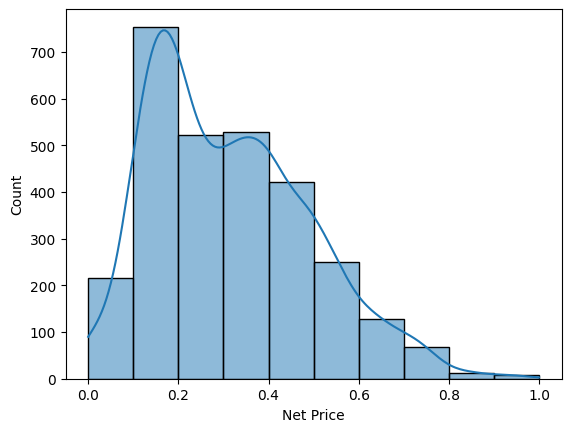

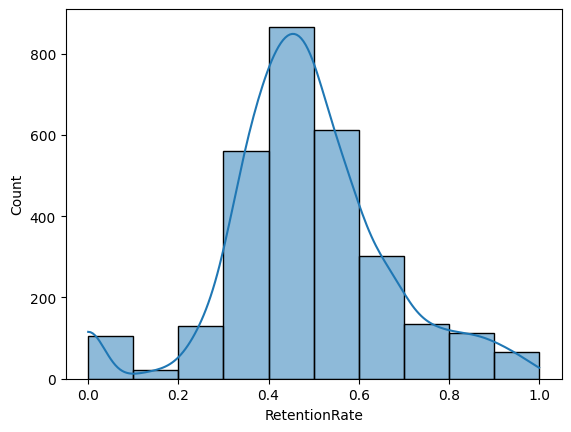

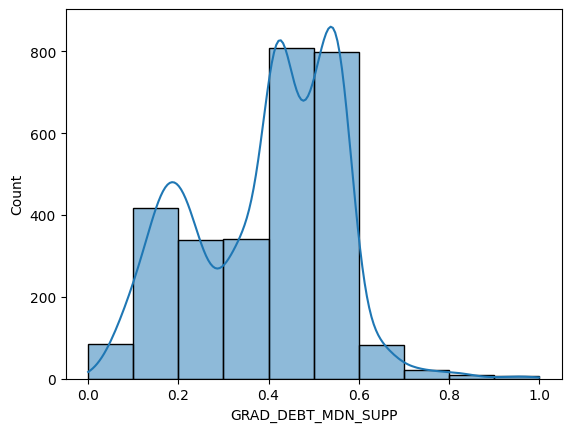

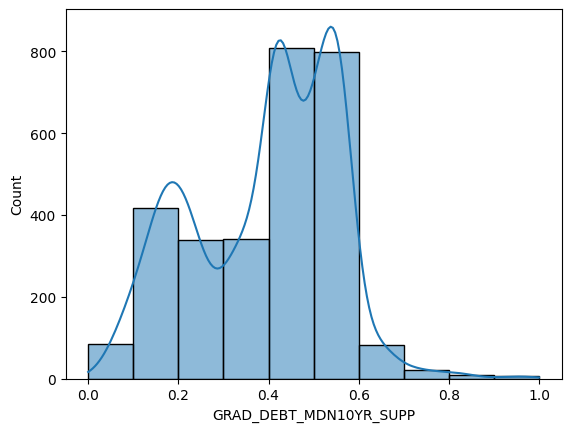

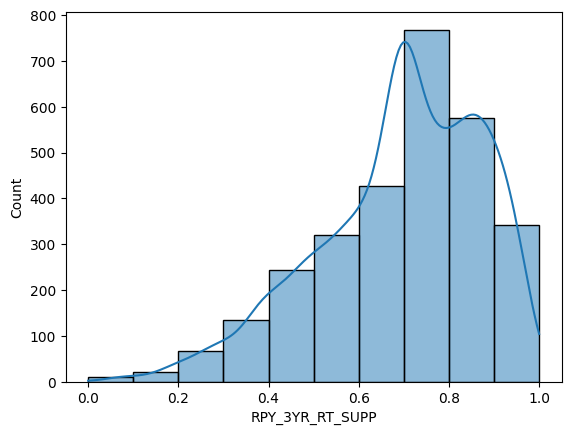

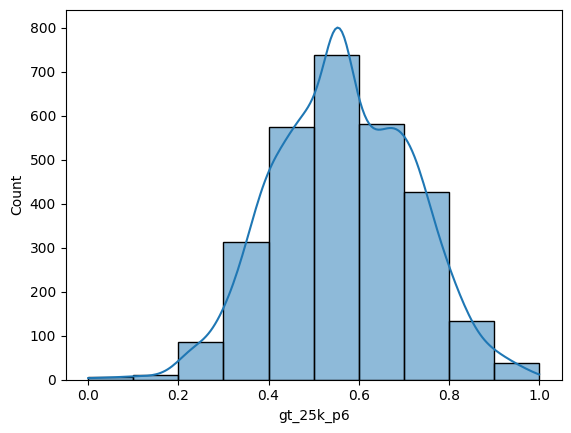

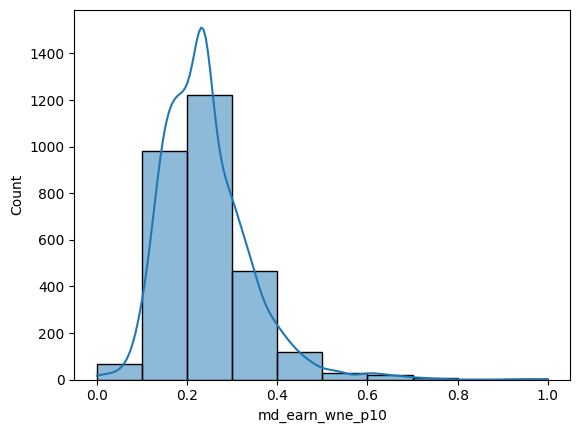

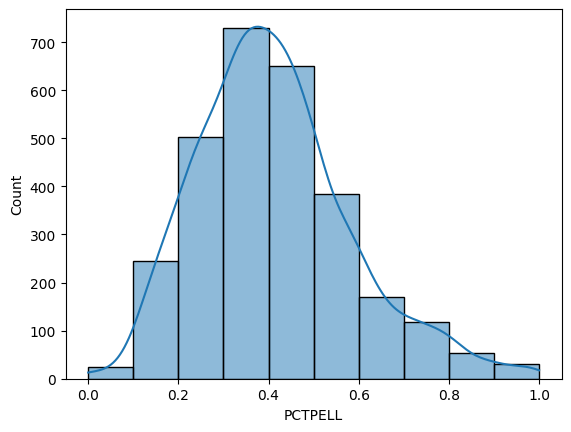

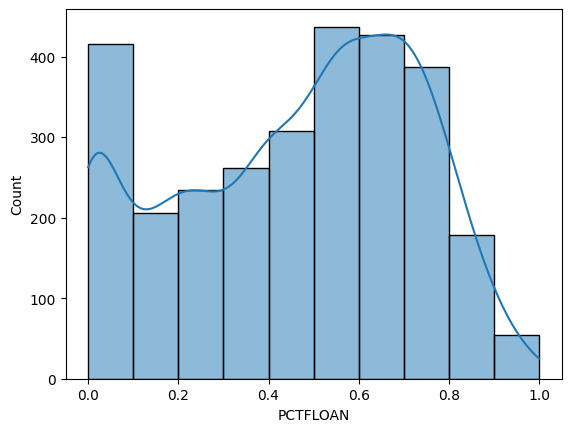

In [10]:
columns_n = data5.drop(columns=['UNITID','SAT','label','UGDS']).columns
for column in columns_n:
  sns.histplot(data5[column] ,bins=10,kde=True)
  plt.show()

这里有两个图双峰了，但感觉还能用一用:)

现在看看相关系数矩阵

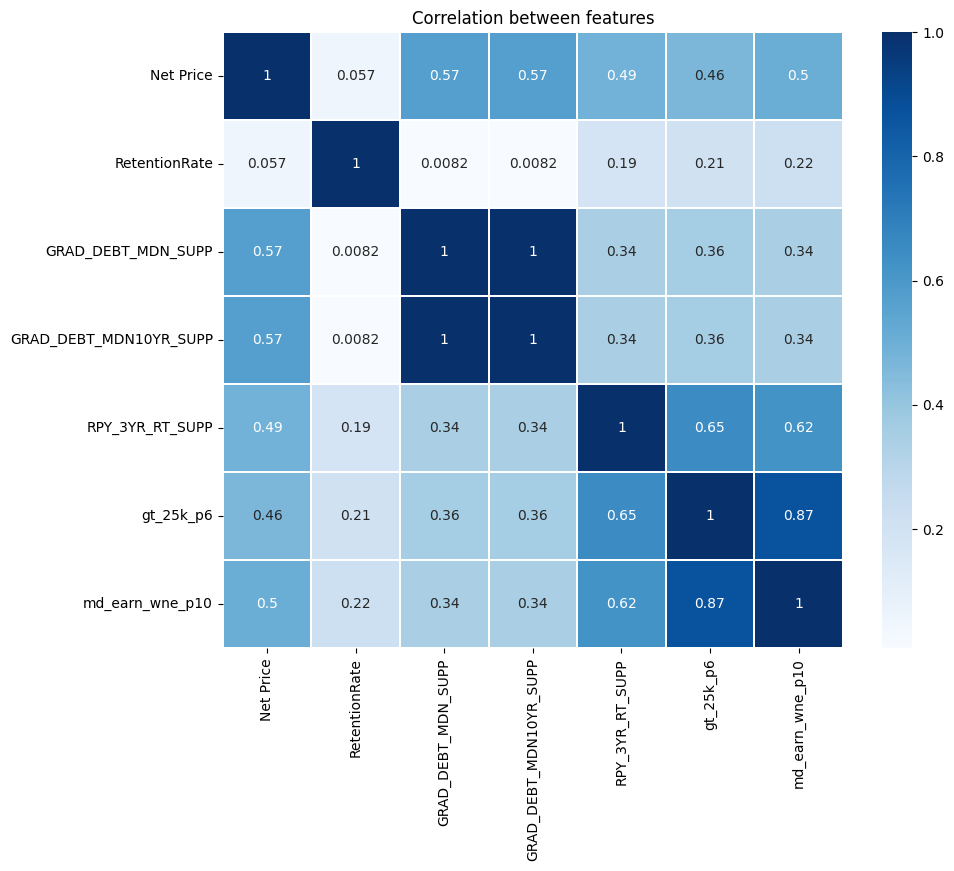

In [11]:
f, ax= plt.subplots(figsize = (10, 8))

corr = data5.drop(columns=['UNITID','SAT','label','UGDS','PCTPELL','PCTFLOAN']).corr(method="pearson")
# print(corr)
sns.heatmap(corr,cmap="Blues", linewidths = 0.05, annot=True,ax = ax)

# 设置Axes的标题
ax.set_title('Correlation between features')
plt.show()

看看线性相关性很强的组合：

<AxesSubplot:xlabel='gt_25k_p6', ylabel='md_earn_wne_p10'>

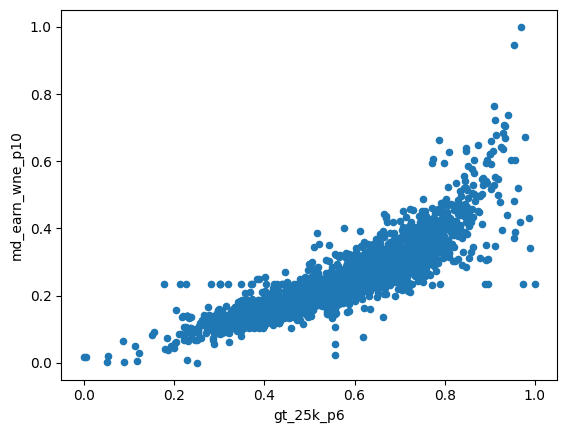

In [12]:
data_a = pd.concat([data5['gt_25k_p6'], data5['md_earn_wne_p10']], axis=1)
data_a.plot.scatter(x='gt_25k_p6', y='md_earn_wne_p10')

<AxesSubplot:xlabel='GRAD_DEBT_MDN_SUPP', ylabel='GRAD_DEBT_MDN10YR_SUPP'>

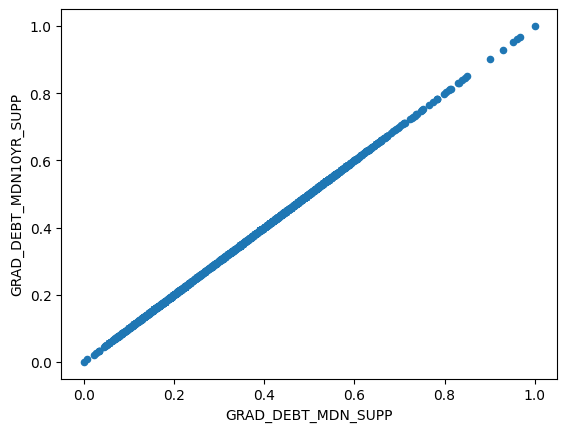

In [13]:
data_b = pd.concat([data5['GRAD_DEBT_MDN_SUPP'], data5['GRAD_DEBT_MDN10YR_SUPP']], axis=1)
data_b.plot.scatter(x='GRAD_DEBT_MDN_SUPP', y='GRAD_DEBT_MDN10YR_SUPP')

<AxesSubplot:xlabel='gt_25k_p6', ylabel='RPY_3YR_RT_SUPP'>

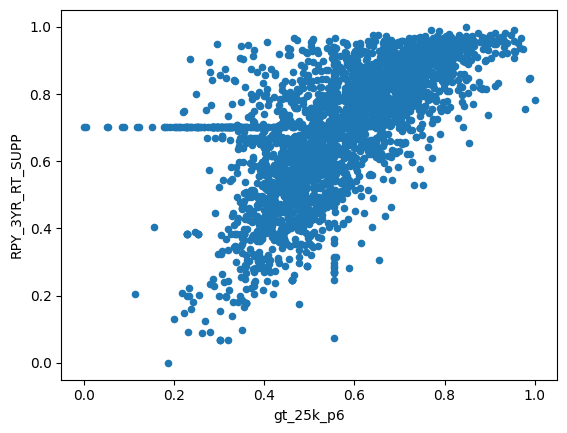

In [14]:
data_c = pd.concat([data5['gt_25k_p6'], data5['RPY_3YR_RT_SUPP']], axis=1)
data_c.plot.scatter(x='gt_25k_p6', y='RPY_3YR_RT_SUPP')

有几组线性相关性还是很强的，可以提取主因子出来
接下来用PCA降维

In [15]:
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

data6=data5.copy()
data6.fillna(0,inplace=True)                            #这里的缺失值是SAT的缺失值，直接用0填补即可
data_n = data6.values[:,:8]

sc = StandardScaler()
norm = sc.fit_transform(data_n)

model = PCA().fit(norm) # 构造并拟合模型
print('特征值是：\n', model.explained_variance_)
print('各主成分贡献率：\n', model.explained_variance_ratio_)
print(model.explained_variance_ratio_[0:4].sum())
print(model.explained_variance_ratio_[0:3].sum())       #前三个指标贡献率已经0.85了，选三个指标


特征值是：
 [3.84157456e+00 1.76463572e+00 8.93236915e-01 5.41239512e-01
 4.60469380e-01 3.76104297e-01 1.25491596e-01 1.56338931e-31]
各主成分贡献率：
 [4.80031691e-01 2.20503612e-01 1.11616219e-01 6.76316739e-02
 5.75388793e-02 4.69968703e-02 1.56810552e-02 1.95356462e-32]
0.8797831951904703
0.8121515213387396


## ROI模型的建立
### O(output)的四个组成
可以看到，前三个成分占比已经达到了0.898由上述PCA分析可得三个主成分：Net Price，Retention Rate，RPY_3YR_RT_SUPP

使用md_earn_wne_p6代表SAG(毕业后薪水)

使用Retention Rate代表RR

使用RPY_3YR_RT_SUPP代表RA（社会回报率）

使用归一化后的SAG减去SAT成绩再进行归一化代表EER（教育提高率），如果某学校没有SAT成绩，则将此权重分给另外三个指标


使用AHP得到归一化后的特征向量，与论文基本一致，值得一提的是，论文把AHP的判断矩阵写错了(错的相当明显)

不过修改了数据之后就跑出来了wwww

可以看到求出CR均小于0，有满意的一致性

In [16]:
from scipy.sparse.linalg import eigs
from numpy import array, hstack
a=array([[1,5,6,3],[1/5,1,2,1/2],[1/6,1/2,1,1/3],
        [1/3,2,3,1]])
L,V=eigs(a,1)
CR=(L-5)/4/1.12  #计算矩阵A的一致性比率
W=V/sum(V); print("最大特征值为：",L)
print("最大特征值对应的特征向量W=\n",W)
print("CR=",CR)

b=array([[1,5,6],[1/5,1,2],[1/6,1/2,1]])
L,V=eigs(b,1)
CR=(L-5)/4/1.12  #计算矩阵A的一致性比率
W=V/sum(V); print("最大特征值为：",L)
print("最大特征值对应的特征向量W=\n",W)
print("CR=",CR)

最大特征值为： [4.03396779+0.j]
最大特征值对应的特征向量W=
 [[0.5767365 +0.j]
 [0.12505245+0.j]
 [0.07663486+0.j]
 [0.22157618+0.j]]
CR= [-0.21563219+0.j]
最大特征值为： [3.02906377+0.j]
最大特征值对应的特征向量W=
 [[0.72584831-0.j]
 [0.17211767-0.j]
 [0.10203403-0.j]]
CR= [-0.43994112+0.j]


我们有两个权重向量V1,V2：
$$
V1=\begin{bmatrix}0.576,0.125,0.077,0.222 \end{bmatrix}\\
V2=\begin{bmatrix}0.726,0.172,0.102 \end{bmatrix}
$$

在计算Output值时，若一个学校的SAT成绩存在，则使用上面的算法，若不存在，则使用下面的算法

$$
Output=\begin{cases}V1\cdot \begin{bmatrix}SAG\quad RR \quad RA \quad EER \end{bmatrix}^T\\V2\cdot \begin{bmatrix}SAG\quad RR \quad RA  \end{bmatrix}^T\end{cases}
$$

## I(Input)的组成

$$
Input = (1-\alpha )+\alpha \times NP
$$
现在是ROI模型里的Input，论文这里取α=0.25，α起修正因子的作用

NP代表Net Price

## U(Urgency)的组成
主要考虑到我们提供援助是慈善活动，要考虑到被援助对象是否紧急

这里使用三个特征来描述对象的紧急性：
1. PCTPELL
2. PCTFLOAN
3. GRAD_DEBT_MDN_SUPP

因为权重比例论文没给，直接用论文的数据就行

下面对三个指标用AHP，论文里没说赋予了多大权重，直接用它的结果就行
$$V3 = [0.25 0.25 0.50]$$
$$
Urgency = V_3 \cdot \begin{bmatrix}PG\quad FL\quad Debt \end{bmatrix}^T
$$

In [17]:
Urgency = pd.concat([data5['PCTPELL'],data5['PCTFLOAN'],data5['GRAD_DEBT_MDN_SUPP']], axis=1)
print(Urgency)

      PCTPELL  PCTFLOAN  GRAD_DEBT_MDN_SUPP
0      0.5843    0.4158            0.317188
1      0.3354    0.0044            0.346109
2      0.2923    0.0283            0.100698
3      0.4031    0.1312            0.134331
4      0.2985    0.1282            0.108027
...       ...       ...                 ...
2903   0.5487    0.3959            0.268528
2904   0.3376    0.4784            0.411184
2905   0.2387    0.4845            0.530657
2906   0.2683    0.4008            0.451240
2907   0.2224    0.4587            0.453142

[2908 rows x 3 columns]


## 灰色模型预测
题目的数据集只有2015年的数据，论文里搞到了不同的学校的从2009-2013年五年内的数据

分别计算了ROI，并用灰色模型预测，得到的结论是比线性拟合更加适合

这里最大的问题是可能题目时间有点久远，已经不提供数据了

## MILF模型的建立
最后实际上使用MILF和考虑时间序列的版本，给出了两份分配方案

主要目的是最大化总回报，并且限制风险

### 定义风险
$$
r=\frac{\mu _e}{\sigma _e}
$$
其中$\mu _e$代表了md_earn_wne_p6的平均值，$\sigma _e$代表了md_earn_wne_p6的标准差



接下来计算出每个学校的ROI值和$\mu$值

先求Output值：

In [26]:
'''def Get_EER(x):
    if(x['SAT']!=0):
        return x['md_earn_wne_p10']-x['SAT']
    else:
        return 0

def EER_Guiyi(x):
    if(x['SAT']!=0):
        return (x['EER']-x['EER'].min())/((x['EER'].max())-x['EER'].min())
    else:
        return 0

data5['EER']=data5.apply(Get_EER,axis=1)
data5['EER']=data5.apply(EER_Guiyi,axis=1)
'''

data5.fillna(0,inplace=True)                                #先把SAT里的缺失值去掉，方便使用apply函数
def Output(x):
    if(x['SAT']!=0):                                        #如果SAT值缺失了
        return 0.576*x['md_earn_wne_p10']+0.125*x['RetentionRate']+0.077*x['RPY_3YR_RT_SUPP']+0.222*x['SAT']
    else:
        all=0.576+0.125+0.077                               #如果SAT值没有缺失，使用另外一种算法
        return 0.576*x['md_earn_wne_p10']/all+0.125*x['RetentionRate']/all+0.077*x['RPY_3YR_RT_SUPP']/all
data5['Output'] = data5.apply(Output, axis=1)


0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2191    0.0
2192    NaN
2193    NaN
2194    NaN
2195    NaN
Name: EER, Length: 2196, dtype: float64


再求Input值和Urgency值：

In [19]:
data5['Input'] = data5.apply(lambda x:x['Net Price']*0.25*0.75,axis=1)
data5['Urgency'] = data5.apply(lambda x:0.25*x['PCTPELL']+0.25*x['PCTFLOAN']+0.5*x['GRAD_DEBT_MDN_SUPP'],axis=1)

根据公式：
$$
ROI=\frac{Input}{Output}\times Urgency
$$
直接计算出ROI就好了

再根据公式：
$$
r=\frac{\mu _e}{\sigma _e}
$$
计算出Risk值

在前面插值步骤已经求出了Risk数组，里面对应的就是Risk值，现在只需要再加入到数据中即可

In [20]:
data5['ROI']=data5.apply(lambda x:x['Input']/x['Output']*x['Urgency'],axis=1)       #求出ROI
def CalRisk(x):
    return Risk[int(x['label'])]
data5['Risk']=data5.apply(CalRisk,axis=1)                                           #求出Risk
#这里没有说Risk具体的求法，我直接在同一类下求了

## 规划求解
$$
max\sum_{i\in S}ROI_ix_i\\ s.t.\begin{cases} \sum_{i\in S}x_i \leq A\\ \sum_{i\in S}r_ix_i\leq A\cdot r^{max}\\ N^{min}\leq 
\sum_{i\in S}y_i\leq N^{max}\\ A_i^{min}y_i\leq x_i\leq A_i^{min}y_i\quad \forall i\in S\\ s_iy_i\leq S^{min}\qquad \forall i \in S \end{cases}
$$


In [21]:
data5=data5[data5['UGDS']>=1000]
data5.reset_index(drop=True,inplace=True)
#这一步是筛选出人数大于1000的学校，模型认为学校人数过少援助的效果就不明显

In [22]:
from pyscipopt import Model
from pyscipopt import quicksum
#这里使用了SCIP库来求解

ROIs=data5['ROI'].tolist()
ROIs=np.array(ROIs)
#把ROI值转为列表
Stus=data5['UGDS'].tolist()
Stus=np.array(Stus)
#把学生数量值转为列表
A_min=5000000
S_min=1000
N_max=20
N_min=10
b=3000
A=100000000
#定义各个量
c1=np.ones(len(Stus)).tolist()
c2=data5['Risk'].tolist()
#c1里全是1，c2里存的是Risk值
r_max = 1
#可承受的最大风险


#接下来使用SCIP模块求解
model = Model("puzzle")     #定义问题
x,y={},{}                   #多变量求解的定义
for i in range(len(Stus)):  #添加变量
    x[i]=model.addVar(lb=0,ub=None,vtype='C',name='x'+str(i))       #x表示投资变量，下界为0，上界为正无穷，类型为连续值
    y[i]=model.addVar(lb=0,ub=1,vtype='I',name='y'+str(i))          #y表示是否在投资列表内，下界为0，上界为1，类型为离散值（整型）
model.setObjective(
        quicksum(ROIs[i]*x[i] for i in range(len(Stus))),           #设置目标函数
        "maximize")   
model.addCons(quicksum(c1[i]*x[i] for i in range(len(Stus)))<=A)                 #总投资上界
model.addCons(quicksum(c2[i]*x[i] for i in range(len(Stus)))<=A*r_max)           #总风险上界
model.addCons(quicksum(c1[i]*y[i] for i in range(len(Stus)))<=N_max)             #总推荐学校数上界
model.addCons(N_min<=(quicksum(c1[i]*y[i] for i in range(len(Stus)))))           #总推荐学校数下界
for i in range(len(Stus)):
    model.addCons(A_min*y[i]<=x[i])
    model.addCons(x[i]<=A_min+b*Stus[i]*y[i])                                   #投资量限制上下界
model.optimize()                                                                #求解问题
print("Optimal value:", model.getObjVal())                                      #输出最优值


Optimal value: 41450782.66969465


In [23]:
#输出结果
results=model.getBestSol()
#results_filter={res_key:res_val for res_key,res_val in results.items() if res_val > 0}
x_res0,y_res0=[],[]
for i in range(len(Stus)):
    x_res0.append(model.getVal(x[i]))
    y_res0.append(model.getVal(y[i]))
x_res=np.array(x_res0)
y_res=np.array(y_res0)
np.nonzero(x_res)
data6=data5['UNITID']
xs,ys=[],[]
for i in range(len(x_res)):
    if(x_res[i]>0):
        xs.append(int(data6.loc[i]))
        ys.append(x_res[i])
        print(int(data6.loc[i]))
        print(x_res[i])
        print(' ')
        #将结果保存在xs和ys内，方便后续绘图

199643
10769000.0
 
132602
14050000.0
 
199582
8897000.0
 
438151
12146000.0
 
217721
12536000.0
 
201964
5000000.0
 
165802
10199000.0
 
101912
5000000.0
 
138947
12887000.0
 
198862
8516000.0
 


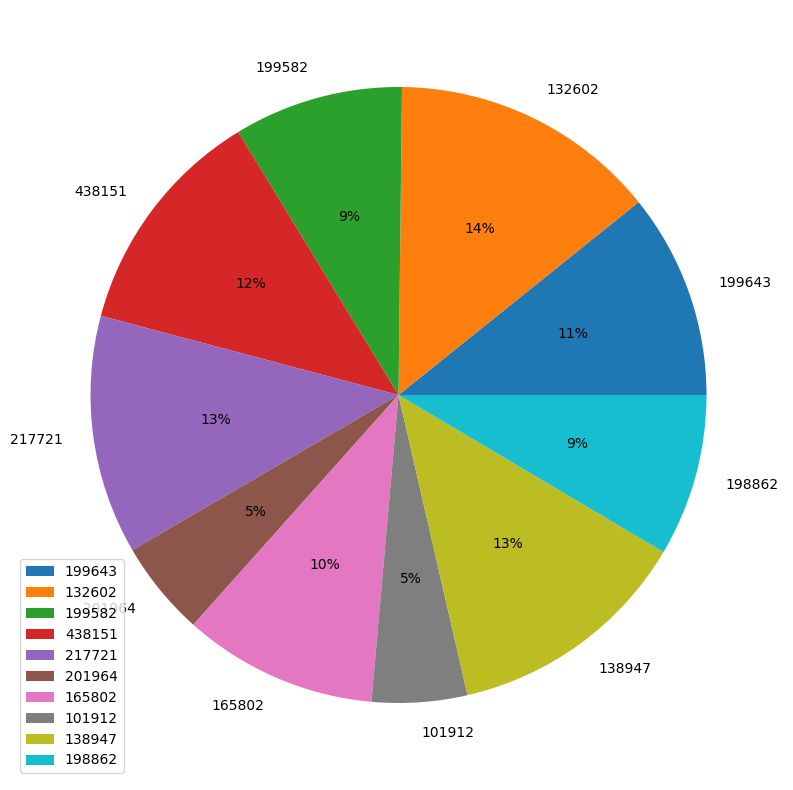

In [24]:
import matplotlib.pyplot as plt
import matplotlib
pieplot=dict(zip(xs,ys))
plt.figure(1 , figsize = (20 ,10))
plt.pie(ys,autopct='%.f%%',labels=xs)
plt.legend()

#画饼图，描述学校分布

## 时间序列+规划
这里作者来了一句：

 the value of ROIt and rt is determined by the previous calculation.

 这就要回到之前灰色预测模型那里了

 因为这里没有2009-2013年五年内的数据，所以这里为了方便直接伪造一下数据吧，直接凭感觉，每年ROI都加一个0.001，风险r每年降低0.001

In [25]:
ROIt=np.ones((5,len(Stus)))
rt=np.ones((5,len(Stus)))
for i in range(5):
    for j in range(len(ROIs)):
        ROIt[i][j]=ROIs[i]+0.001*j

#因为文中是尽可能保证高收益而忽略风险，这里直接忽略风险的变化即可

from pyscipopt import Model
from pyscipopt import quicksum

ROIs=data5['ROI'].tolist()
ROIs=np.array(ROIs)
Stus=data5['UGDS'].tolist()
Stus=np.array(Stus)
A_min=5000000
S_min=1000
N_max=20
N_min=10
b=3000
A=100000000
c1=np.ones(len(Stus)).tolist()
c2=data5['Risk'].tolist()
r_max=1

model = Model("puzzle")  # model name is optional
xt,yt=[{},{},{},{},{}],[{},{},{},{},{}]
for i in range(5):
    for j in range(len(Stus)):
        xt[i][j]=model.addVar(lb=0,ub=None,vtype='C',name='x'+str(j)+'year'+str(i))
        yt[i][j]=model.addVar(lb=0,ub=1,vtype='I',name='y'+str(j)+'year'+str(i))
model.setObjective(
        quicksum(ROIt[i][j]*xt[i][j] for i in range(5) j in range(len(Stus))),
        "maximize")   
model.addCons(quicksum(c1[i]*xt[i][j] for i in range(5) and j in range(len(Stus)))<=A)
for j in range(len(Stus)):
    for i in range(5):
        model.addCons(A_min*yt[i][j]<=xt[i][j])
        model.addCons(xt[i][j]<=A_min*8000*Stus[j]*yt[i][j])
for t in range(5):
    model.addCons(N_min<=quicksum(c1[t]*yt[t][j] for j in range(len(Stus))))
    model.addCons(quicksum(c1[t]*yt[t][j] for j in range(len(Stus)))<=N_max)
model.optimize()
print("Optimal value:", model.getObjVal())
model.optimize()
print("Optimal value:", model.getObjVal())



SyntaxError: invalid syntax (1572322461.py, line 33)

## 灵敏度分析
文中给了以下三种分析：

### 改变风险接受度
通过调整r_max(最大可承受风险)，看最优值的大小变化
### 改变每年投资学校数量
这个只需要调整N_min=N_max=i，然后调一下即可
### 改变投资策略
在时间策略模型下分别用这四种投资方案来跑：
1. 一年全投资完
2. 给一个学校的投资平均到每年
3. 每年投资分配不均匀，但是规定了上下界
4. 每年随便投资，不加限制

实际结果是方案4得到了最高的回报，但是作者在文章中说前两年分配钱的总数仅占总资金的一半，不太实际，所以推荐了方案3
